## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/tmp/.fastai/data/camvid/codes.txt'),
 PosixPath('/tmp/.fastai/data/camvid/images'),
 PosixPath('/tmp/.fastai/data/camvid/labels'),
 PosixPath('/tmp/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/tmp/.fastai/data/camvid/images/0016E5_07959.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0001TP_009840.png'),
 PosixPath('/tmp/.fastai/data/camvid/images/0006R0_f01470.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/tmp/.fastai/data/camvid/labels/Seq05VD_f03240_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0001TP_007080_P.png'),
 PosixPath('/tmp/.fastai/data/camvid/labels/0016E5_07830_P.png')]

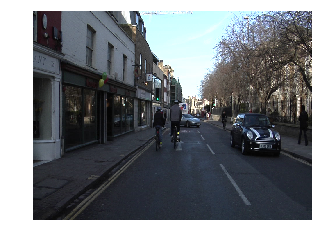

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

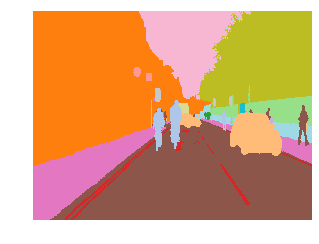

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          [ 4,  4,  4,  ..., 26, 26, 26],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

## Datasets

In [13]:
size = src_size//2
bs=8

In [14]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [15]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

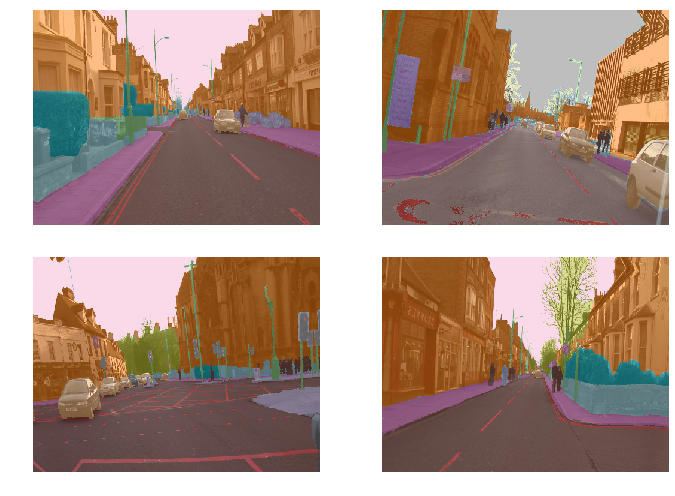

In [16]:
data.show_batch(2, figsize=(10,7))

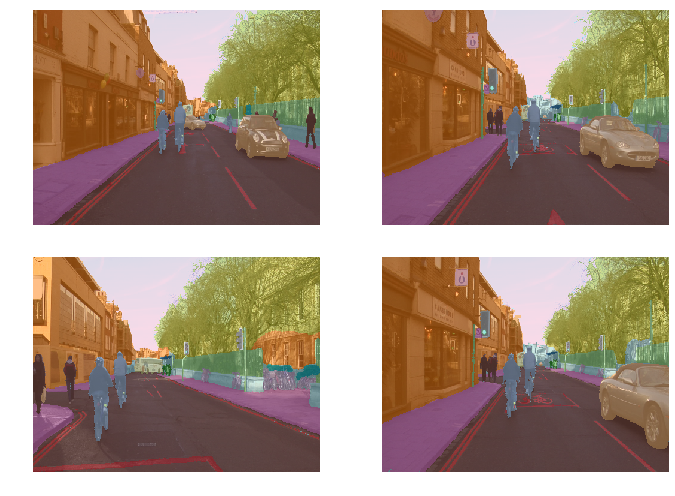

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [18]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [19]:
metrics=acc_camvid
# metrics=accuracy

In [20]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.torch/models/resnet34-333f7ec4.pth
87306240it [00:00, 105506807.20it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


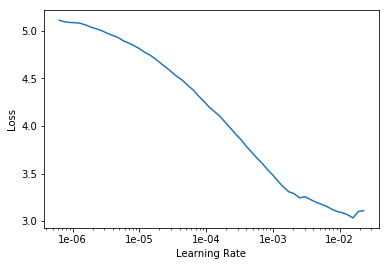

In [22]:
lr_find(learn)
learn.recorder.plot()

In [23]:
lr=3e-3

In [24]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.300526,0.869717,0.788584,01:42
1,0.866784,0.654836,0.825553,01:38
2,0.740373,0.613404,0.841128,01:38
3,0.639981,0.494467,0.863429,01:39
4,0.692675,0.654879,0.831826,01:38
5,0.646638,0.505686,0.858791,01:38
6,0.674123,0.577929,0.847480,01:39
7,0.570125,0.397300,0.890267,01:39
8,0.567670,0.433682,0.875769,01:38
9,0.471442,0.348876,0.894675,01:38


In [25]:
learn.save('stage-1')

In [26]:
learn.load('stage-1');

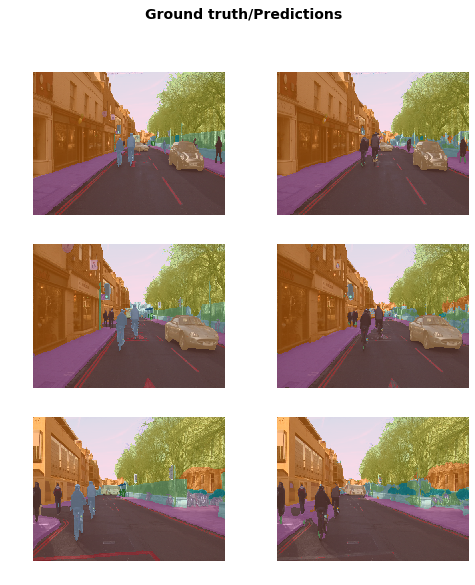

In [27]:
learn.show_results(rows=3, figsize=(8,9))

In [28]:
learn.unfreeze()

In [29]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.400436,0.341273,0.894813,01:41
1,0.395024,0.341645,0.895829,01:40
2,0.387332,0.340636,0.895725,01:40
3,0.376249,0.323876,0.904850,01:40
4,0.370281,0.316087,0.905837,01:40
5,0.360794,0.307003,0.914160,01:41
6,0.346844,0.310851,0.909760,01:40
7,0.335385,0.309249,0.912170,01:41
8,0.320491,0.286982,0.920300,01:41
9,0.314334,0.303899,0.913658,01:41


In [31]:
learn.save('stage-2');

In [32]:
size = src_size
bs=3

In [33]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [34]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [35]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


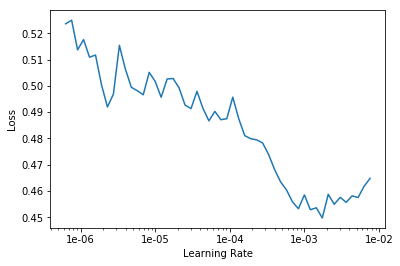

In [36]:
lr_find(learn)
learn.recorder.plot()

In [37]:
lr=1e-3

In [38]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.381317,0.337250,0.905149,03:54
1,0.353176,0.297024,0.916632,03:50
2,0.348291,0.302984,0.917144,03:50
3,0.333502,0.361798,0.910160,03:50
4,0.332822,0.269527,0.924002,03:51
5,0.346638,0.322418,0.897147,03:50
6,0.339489,0.266577,0.926848,03:50
7,0.365064,0.305160,0.922494,03:50
8,0.282233,0.269700,0.924274,03:50
9,0.241580,0.251570,0.929508,03:50


In [39]:
learn.save('stage-1-big')

In [40]:
learn.load('stage-1-big');

In [41]:
learn.unfreeze()

In [42]:
lrs = slice(1e-6,lr/10)

In [43]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.227530,0.244566,0.931411,03:57
1,0.228316,0.247082,0.931264,03:56
2,0.222843,0.238473,0.933655,03:56
3,0.226265,0.243365,0.932369,03:56
4,0.218627,0.249005,0.930960,03:56
5,0.219143,0.240179,0.933432,03:56
6,0.204050,0.240065,0.934419,03:56
7,0.189324,0.238136,0.935086,03:56
8,0.192234,0.241098,0.935031,03:56
9,0.192732,0.241287,0.934875,03:56


In [44]:
learn.save('stage-2-big')

In [45]:
learn.load('stage-2-big');

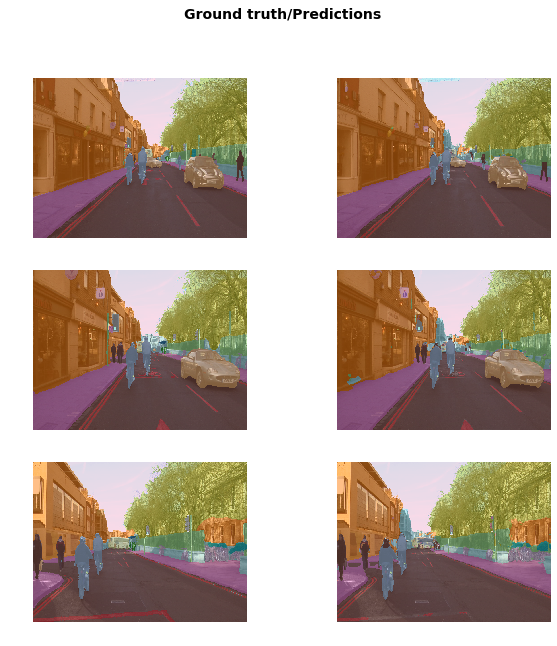

In [46]:
learn.show_results(rows=3, figsize=(10,10))